In [1]:
import caveclient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Users/anamika.agrawal/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# links to connectomics data
# google bucket: gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups
# amazon aws: s3://em-connectomics-data/

In [3]:
client  = caveclient.CAVEclient('minnie65_public_v343')


In [4]:
client.materialize.get_tables()

['synapses_pni_2',
 'nucleus_neuron_svm',
 'nucleus_detection_v0',
 'functional_coreg',
 'allen_v1_column_types_slanted',
 'aibs_column_nonneuronal',
 'func_unit_em_match_release',
 'proofreading_status_public_release',
 'aibs_soma_nuc_metamodel_preds_v117']

In [46]:
import pandas as pd
import cloudfiles
import os
import io
import re
import sys
from meshparty import meshwork

def fix_local_cloudpath(cloudpath):
    if "://" not in cloudpath:
        dir, _ = os.path.split(cloudpath)
        if len(dir) == 0:
            cloudpath = './' + cloudpath
        cloudpath = "file://" + cloudpath
    return cloudpath

def get_path_files(cloudpath, regex_template=None):
    cloudpath = fix_local_cloudpath(cloudpath)
    cf = cloudfiles.CloudFiles(cloudpath,use_https=True)
    if regex_template is None:
        filenames = [f"{cloudpath}/{fn}" for fn in cf.list()]
    else:
        filenames = [f"{cloudpath}/{fn}" for fn in cf.list() if re.search(regex_template, fn) is not None]
    return filenames

def read_json_file(cloudpath):
    path = fix_local_cloudpath(cloudpath)
    folder, file = os.path.split(cloudpath)
    cf = cloudfiles.CloudFiles(folder)
    return cf.get_json(file)


def read_bytes(path):
    path = fix_local_cloudpath(path)
    cloudpath, file = os.path.split(path)
    cf = cloudfiles.CloudFiles(cloudpath)
    byt = io.BytesIO(cf.get(file))
    return byt


def read_csv(path, **kwargs):
    byt = read_bytes(path)
    df = pd.read_csv(byt, **kwargs)
    return df

def read_h5(path, **kwargs):
    byt = read_bytes(path)
    if (sys.getsizeof(byt) < 1e3):
        nrn = '' #return empty
    else:
        nrn = meshwork.load_meshwork(byt)
    return nrn


In [6]:
from cloudfiles import CloudFiles, dl
cf = CloudFiles('gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups',use_https=True,progress=True)
from cloudfiles import compression, paths
#s3path = 's3://em-connectomics-data/'
gspath = 'gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups'
cloudpath = fix_local_cloudpath(gspath)
#cloudpath = paths.to_https_protocol(cloudpath)
filenames = [f"{cloudpath}/{fn}" for fn in cf.list()]


In [44]:
byt = read_bytes(os.path.join(data_root,folder_name,mesh_filename))

In [47]:
nrn = read_h5(os.path.join(data_root,folder_name,mesh_filename))
emptynrn = read_h5(os.path.join(data_root,mesh_filename))

In [54]:
bool(nrn)

True

In [47]:
np.shape(filenames)

(156528,)

In [8]:
byt = read_bytes(filenames[0])

In [10]:
from meshparty import meshwork
nrn = meshwork.load_meshwork(byt)

In [14]:
nrn = read_h5(filenames[0])

In [15]:
filenames[0]

'gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups/864691134884741370_195614/864691134884741370_195614.h5'

In [16]:
nrn.skeleton.vertices

array([[ 447792.,  725240.,  971920.],
       [ 448120.,  726016.,  970840.],
       [ 448568.,  726064.,  973240.],
       ...,
       [ 665936.,  680728., 1056880.],
       [ 666080.,  680952., 1056400.],
       [ 572608.,  695360., 1054320.]])

In [17]:
# connectomics imports
import platform
import os

    
# OR if you'd like to override the auto options
data_root = "gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups/"

In [18]:
# this is the EM specific package for querying the EM data
from caveclient import CAVEclient
# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy as sc
%matplotlib widget

In [19]:
tun_orac=pd.read_feather('tuning_curve_oracle.feather')

In [20]:
coreg_df = client.materialize.query_table('functional_coreg')
coreg_merge=pd.merge(coreg_df, tun_orac,
         right_on=['scan_session', 'scan_idx', 'unit_id'], left_on=['session', 'scan_idx', 'unit_id'])

In [21]:
highDSIdf = coreg_merge[coreg_merge.dsi>0.3]

In [22]:
highDSIdf.columns

Index(['id', 'valid', 'pt_supervoxel_id', 'pt_root_id', 'session', 'scan_idx',
       'unit_id', 'pt_position', 'animal_id', 'scan_session', 'direction',
       'response_mean', 'osi', 'dsi', 'pref_dir', 'pref_ori', 'oracle'],
      dtype='object')

In [23]:
i=0
neuron_id = highDSIdf.iloc[i].pt_root_id
#print(neuron_id)
    
neuron_soma_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')
if (len(neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values) == 0):
    print('not in neuron_soma_df')
        
nuc_id = neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
mesh_filename = f"{neuron_id}_{nuc_id}.h5"
folder_name = f"{neuron_id}_{nuc_id}"

In [ ]:
# alternate way using forrest's method
import cloudfiles
import io
from meshparty import meshwork
import matplotlib.pyplot as plt
import os
cloud_path = 'gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups'
cf = cloudfiles.CloudFiles(cloud_path, use_https=True)
byt=cf.get('864691134884741370_195614/864691134884741370_195614.h5')
bio = io.BytesIO(byt)
mw=meshwork.load_meshwork(bio)

In [25]:
os.path.join(data_root,mesh_filename)

'gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups/864691135467558284_583817.h5'

100%|█████████████████████████████████████████████| 2/2 [00:10<00:00,  5.17s/it]


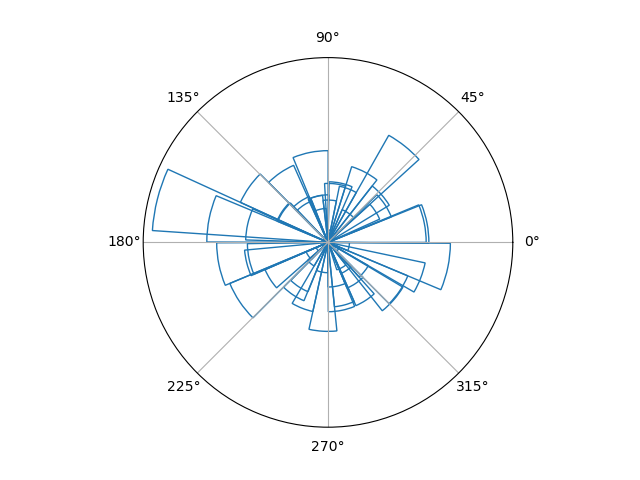

In [57]:
# iterate over valid neurons (shorter list) - get their DSIs, OSIs, pref dir, pref or
# get all of these from morphology - as well as angular heterogeneity metric
# save calculated stuff to dataframes
import copy
from tqdm import tqdm
from meshparty import meshwork
from angularUtils import *
from meshparty.skeleton import resample
from scipy import signal
#coreg_df_DSIordered = pd.concat([highDSIdf, lowDSIdf])
#coreg_df_DSIordered = coreg_df_DSIordered.sort_values(by=['DSI'],ascending=False)
coreg_df_DSIordered = highDSIdf.sort_values(by=['dsi'],ascending=False)
Ncells = len(coreg_df_DSIordered)
pref_dir_morph = np.zeros((Ncells,1))
pref_dir_morph[:] = np.nan
pref_or_morph = np.zeros((Ncells,1))
pref_or_morph[:] = np.nan
DSI_act = np.zeros((Ncells,1))
DSI_act[:] = np.nan
OSI_act = np.zeros((Ncells,1))
OSI_act[:] = np.nan
nuc_id_list = np.zeros((Ncells,1))
nuc_id_list[:] = np.nan
mesh_files = []
pref_dir_act = np.zeros((Ncells,1))
pref_dir_act[:] = np.nan
pref_or_act = np.zeros((Ncells,1))
pref_or_act[:] = np.nan
angularHet_basal = np.zeros((Ncells,1))
angularHet_basal[:] = np.nan
angularHet_apical = np.zeros((Ncells,1))
angularHet_apical[:] = np.nan
nuc_type = [None] * Ncells
#nuc_type[:] = np.nan
fig,ax = plt.subplots(subplot_kw={'projection': 'polar'})

for i in tqdm(range(2)):
    neuron_id = coreg_df_DSIordered.iloc[i].pt_root_id
    #print(neuron_id)
    
    neuron_soma_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')
    if (len(neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values) == 0):
        continue
        
    nuc_id = neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
    nuc_id_list[i] = nuc_id
    mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    folder_name = f"{neuron_id}_{nuc_id}"
    
    #nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_filename))
    nrn = read_h5(os.path.join(data_root,folder_name,mesh_filename))
    # if no h5 file is detected, continue without implementing rest of the loop
    if (not(nrn)):
        continue
    
    pref_dir_act[i] = coreg_df_DSIordered.iloc[i].pref_dir * (np.pi/180)
    pref_or_act[i] = coreg_df_DSIordered.iloc[i].pref_ori * (np.pi/180)
    DSI_act[i] = coreg_df_DSIordered.iloc[i].dsi
    OSI_act[i] = coreg_df_DSIordered.iloc[i].osi
    
    #nuc_type.append(neuron_soma_df.query(f'pt_root_id=={neuron_id}').cell_type.values[0])
    nuc_type[i] = neuron_soma_df.query(f'pt_root_id=={neuron_id}').cell_type.values[0]
    #mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    mesh_files.append(mesh_filename)

    
    
    # get basal dendrite mesh for pref dir
    basal_dendrite_mesh = nrn.anno.basal_mesh_labels.mesh_index
    basal_dendrite_skel = nrn.anno.basal_mesh_labels.skel_index
    basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    
    
    # get apical dendrite mesh
    apical_dendrite_mesh = nrn.anno.apical_mesh_labels.mesh_index
    apical_dendrite_skel = nrn.anno.apical_mesh_labels.skel_index
    apical_dendrite_mask = nrn.anno.apical_mesh_labels.skel_index.to_mesh_mask
    
    #syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    #syndf_apical = nrn.anno.post_syn.filter_query(apical_dendrite_mask).df
    #syndf_axon = nrn.anno.pre_syn.df

    #syn_pos_apical = np.vstack(syndf_apical['ctr_pt_position'].values)
    #syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    #syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    #skeleton_vertices = syn_pos_basal_norm
    
    #
    #syn_pos_axon = np.vstack(syndf_axon['ctr_pt_position'].values)
    #syn_pos_axon_norm = np.column_stack((syn_pos_axon[:,0]*4, syn_pos_axon[:,1]*4, syn_pos_axon[:,2]*40))
    #skeleton_vertices = syn_pos_axon_norm
    
    # get pref morph dir from basal part
    skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.basal_mesh_labels.skel_mask)]
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    if (len(skeleton_vertices) == 0):
        continue
    #somapos = [nrn_somapos[0], nrn_somapos[1], nrn_somapos[2]]
    
    
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    #skel_pos_radial_farther = skel_pos_radial[skel_pos_radial[:,0] > 0.2*np.max(skel_pos_radial[:,0])]
    x = skel_pos_radial[:,1]
    #x = skel_pos_radial_farther[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    #bins = np.linspace(-np.pi, np.pi, num=17)
    n, bins, patches = circular_hist(ax, x, weights=np.ones_like(x), bins=16, density=True, offset=0, gaps=True)
    #n, bins = np.histogram(x, bins=bins)
    #pref_dir_morph[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    pref_dir_morph[i] = bins[n.argmax()]
    #theta[i] = np.arctan2(majorAxis[1],majorAxis[0]) + np.pi
    #print(pref_dir_morph[i])
    angularHet_basal[i] = np.max(n)/np.mean(n)
    
    # get pref morph or from apical part
    skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.apical_mesh_labels.skel_mask)]
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    if (len(skeleton_vertices) == 0):
        continue
    #somapos = [nrn_somapos[0], nrn_somapos[1], nrn_somapos[2]]
    
    
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    #skel_pos_radial_farther = skel_pos_radial[skel_pos_radial[:,0] > 0.2*np.max(skel_pos_radial[:,0])]
    x = skel_pos_radial[:,1]
    #x = skel_pos_radial_farther[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    #bins = np.linspace(-np.pi, np.pi, num=17)
    n, bins, patches = circular_hist(ax, x, weights=np.ones_like(x), bins=16, density=True, offset=0, gaps=True)
    #n, bins = np.histogram(x, bins=bins)
    #pref_dir_morph[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    pref_or_morph[i] = bins[n.argmax()]
    #theta[i] = np.arctan2(majorAxis[1],majorAxis[0]) + np.pi
    #print(pref_or_morph[i])
    angularHet_apical[i] = np.max(n)/np.mean(n)
    
    


    

In [12]:
prf_df=client.materialize.query_table('proofreading_status_public_release')

In [13]:
ct_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117', desired_resolution=[1000,1000,1000])

In [14]:
nuc_df = client.materialize.query_table('nucleus_detection_v0', split_positions=True, desired_resolution=[1000,1000,1000])

In [15]:
nuc_df=pd.merge(nuc_df, ct_df[['target_id', 'cell_type']], left_on='id', right_on='target_id', how='left')

In [16]:
prfct_df=pd.merge(prf_df, ct_df, on='pt_root_id', how='left')

In [17]:
coregDF=pd.read_feather('coregDF_withMorph2.feather')
l23_ext_coreg=coregDF[coregDF.pt_root_id.isin(prfct_df.query('cell_type=="4P"').query('status_axon=="extended"').pt_root_id.values)]

In [18]:
dsi_osi_df = pd.read_feather('coreg_all_good_scans_dsi_osi.feather')
coreg_df = client.materialize.query_table('functional_coreg')
dsi_osi_df=pd.merge(coreg_df, dsi_osi_df[['pref_dir', '0.0', '22.5', '45.0', '67.5', '90.0', '112.5',
       '135.0', '157.5', '180.0', '202.5', '225.0', '247.5', '270.0', '292.5',
       '315.0', '337.5', 'null_dir', 'DSI', 'Act_Pref_Dir', 'OSI',
       'Act_Pref_Or', 'pref_or', 'null_or','id']], on='id')

In [19]:
root_id = l23_ext_coreg.iloc[0,:].pt_root_id

In [13]:
dsi_self = pd.merge(dsi_osi_df, dsi_osi_df, on='pt_root_id', how='inner')
dsi_self=dsi_self[dsi_self.id_x!=dsi_self.id_y]

<AxesSubplot:xlabel='pref_dir_x', ylabel='pref_dir_y'>

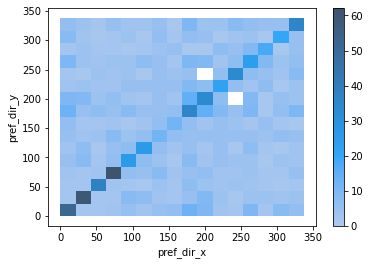

In [14]:
f, ax = plt.subplots()
sns.histplot(data=dsi_self, x='pref_dir_x', y='pref_dir_y',bins=16, ax=ax, cbar=True)


In [18]:
dangle = dsi_self.pref_dir_x - dsi_self.pref_dir_y
dsi_self['dpref_dir']=np.arctan2(np.sin(dangle), np.cos(dangle))

In [19]:
dsi_self['avg_DSI']=dsi_self.DSI_x/2 + dsi_self.DSI_y/2
dsi_self['avg_act']=dsi_self.Act_Pref_Dir_x/2 + dsi_self.Act_Pref_Dir_y/2

In [24]:
dsi_self.columns

Index(['id_x', 'valid_x', 'pt_supervoxel_id_x', 'pt_root_id', 'session_x',
       'scan_idx_x', 'unit_id_x', 'pt_position_x', 'pref_dir_x', '0.0_x',
       '22.5_x', '45.0_x', '67.5_x', '90.0_x', '112.5_x', '135.0_x', '157.5_x',
       '180.0_x', '202.5_x', '225.0_x', '247.5_x', '270.0_x', '292.5_x',
       '315.0_x', '337.5_x', 'null_dir_x', 'DSI_x', 'Act_Pref_Dir_x', 'OSI_x',
       'Act_Pref_Or_x', 'pref_or_x', 'null_or_x', 'id_y', 'valid_y',
       'pt_supervoxel_id_y', 'session_y', 'scan_idx_y', 'unit_id_y',
       'pt_position_y', 'pref_dir_y', '0.0_y', '22.5_y', '45.0_y', '67.5_y',
       '90.0_y', '112.5_y', '135.0_y', '157.5_y', '180.0_y', '202.5_y',
       '225.0_y', '247.5_y', '270.0_y', '292.5_y', '315.0_y', '337.5_y',
       'null_dir_y', 'DSI_y', 'Act_Pref_Dir_y', 'OSI_y', 'Act_Pref_Or_y',
       'pref_or_y', 'null_or_y', 'dpref_dir', 'avg_DSI', 'avg_act'],
      dtype='object')

<AxesSubplot:xlabel='dpref_dir', ylabel='avg_DSI'>

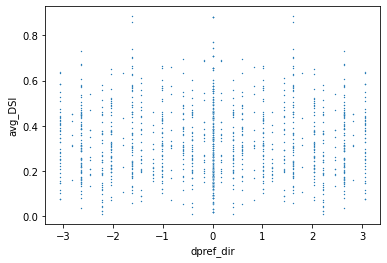

In [23]:
f, ax = plt.subplots()
sns.scatterplot(data=dsi_self,x='dpref_dir', y='avg_DSI',s=2,ax=ax)

<AxesSubplot:xlabel='dpref_dir', ylabel='avg_act'>

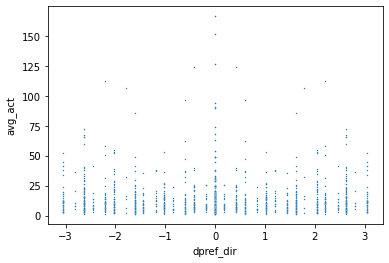

In [25]:
f, ax = plt.subplots()
sns.scatterplot(x='dpref_dir', y='avg_act',
                data=dsi_self, s=2,ax=ax)

<AxesSubplot:xlabel='dpref_dir', ylabel='avg_act'>

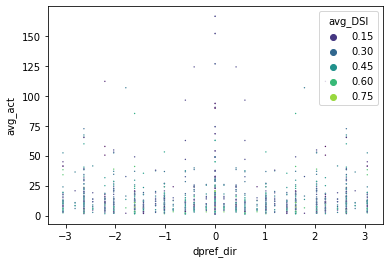

In [26]:
f, ax = plt.subplots()
sns.scatterplot(x='dpref_dir', y='avg_act', 
                hue='avg_DSI',palette=plt.cm.viridis, 
                data=dsi_self, s=2,ax=ax)

<AxesSubplot:xlabel='pref_dir_x', ylabel='pref_dir_y'>

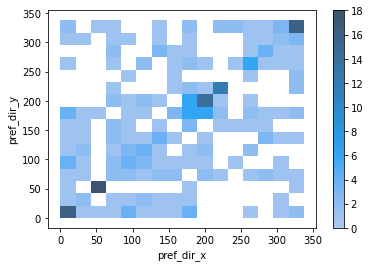

In [27]:
f, ax = plt.subplots()
sns.histplot(data=dsi_self.query('avg_act>20'), x='pref_dir_x', y='pref_dir_y',bins=16, ax=ax, cbar=True)


<AxesSubplot:xlabel='dpref_dir', ylabel='OSI_x'>

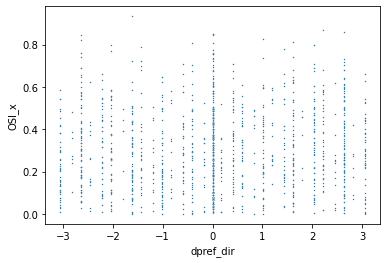

In [28]:
f, ax = plt.subplots()
sns.scatterplot(x='dpref_dir', y='OSI_x', data=dsi_self, s=2,ax=ax)

In [29]:
dsi_self.pref_dir_x.value_counts().shape

(16,)

In [30]:
dsi_osi_df.shape, dsi_self.shape

((8944, 32), (1586, 66))

In [31]:
dsi_self.drop_duplicates(subset=['id_x', 'id_y'], keep=False).shape

(1586, 66)

In [32]:
dsi_self.shape

(1586, 66)

In [33]:
dsi_self.shape

(1586, 66)

In [34]:
dsi_osi_df.query(f'pt_root_id=={root_id}')[['scan_idx', 'session','unit_id','pt_root_id', 'DSI','OSI', 'pref_dir', 'pref_or']]

,scan_idx,session,unit_id,pt_root_id,DSI,OSI,pref_dir,pref_or
96,7,4,5564,864691135718541617,0.566859,0.174294,0.0,135.0
1775,5,8,8350,864691135718541617,0.640613,0.491521,157.5,157.5


In [35]:
root_id

864691135718541617

In [36]:
syn_df = client.materialize.synapse_query(pre_ids=root_id,
                                          split_positions=True,
                                          desired_resolution=[1000,1000,1000])

In [152]:
syn_dfm=pd.merge(syn_df, nuc_df, left_on='post_pt_root_id', right_on='pt_root_id', how='inner')

In [153]:
delt_v=syn_dfm[['ctr_pt_position_x', 'ctr_pt_position_y', 'ctr_pt_position_z']].values-syn_dfm[['pt_position_x', 'pt_position_y', 'pt_position_z']].values

In [154]:
syn_dfm[['soma_to_syn_x', 'soma_to_syn_y', 'soma_to_syn_z']]=delt_v

In [155]:
syn_dfm['soma_to_syn_r']=np.linalg.norm(syn_dfm[['soma_to_syn_x', 'soma_to_syn_y', 'soma_to_syn_z']], axis=1)

In [156]:
syn_dfm['theta']=np.arctan2(syn_dfm.soma_to_syn_x, syn_dfm.soma_to_syn_z)

In [157]:
syn_dfm=syn_dfm.drop_duplicates(subset='id_x')

In [180]:
syn_dfm.merge(dsi_osi_df, left_on='post_pt_root_id', right_on='pt_root_id')

,id_x,valid_x,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_position_x,post_pt_position_y,post_pt_position_z,...,292.5,315.0,337.5,null_dir,DSI,Act_Pref_Dir,OSI,Act_Pref_Or,pref_or,null_or
0,133954227,t,642.320,683.584,910.68,86849806009668531,864691135753932237,642.400,683.952,910.80,...,10.911670,8.378872,7.886239,22.5,0.623543,17.120943,0.292127,12.775335,45.0,135.0
1,96423091,t,559.232,633.400,758.36,83962969041459235,864691135753932237,559.272,633.480,758.24,...,10.382027,15.945401,14.627197,90.0,0.273815,36.483517,0.439726,28.641140,90.0,0.0
2,108300450,t,600.680,760.912,696.88,85445041794907457,864691135753932237,600.504,761.152,696.68,...,4.090281,3.615450,5.830765,315.0,0.300496,6.721735,0.487695,5.615542,90.0,0.0
3,126226046,t,634.608,687.112,774.08,86568468002376450,864691135753932237,634.520,686.696,774.28,...,4.090281,3.615450,5.830765,315.0,0.300496,6.721735,0.487695,5.615542,90.0,0.0
4,185393273,t,777.328,667.664,1001.04,91493593638252359,864691135753932237,776.968,668.088,1001.04,...,4.277564,7.762255,6.088434,225.0,0.356171,25.277296,0.496858,18.638725,45.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,182525672,t,755.176,691.992,692.56,90720361079354402,864691135753932237,755.056,692.504,692.72,...,6.535955,19.199238,17.229132,337.5,0.163868,23.982376,0.217886,20.605755,157.5,67.5
136,171726958,t,736.128,696.552,701.08,90087179887496251,864691135753932237,735.792,696.632,701.04,...,3.685940,6.876083,3.689906,135.0,0.136044,6.876083,0.304835,6.224863,22.5,112.5
137,255144807,t,937.856,688.528,748.88,96983042073419955,864691135753932237,937.352,688.712,748.88,...,19.621037,20.112415,28.113522,45.0,0.208059,37.840328,0.230838,31.323238,45.0,135.0
138,125652888,t,623.216,744.896,714.44,86218548225528708,864691135753932237,623.048,745.072,714.56,...,0.933556,1.406676,2.144675,180.0,0.324549,3.715112,0.494895,2.954076,22.5,112.5


(-150.0, 150.0)

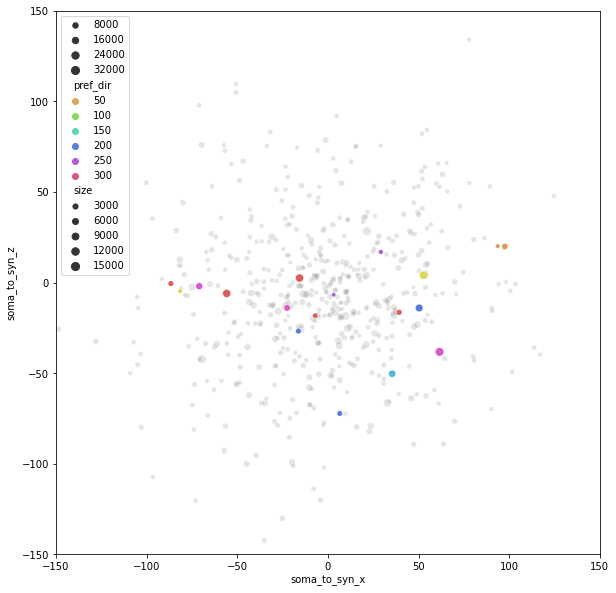

In [215]:
f, ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x='soma_to_syn_x', y='soma_to_syn_z',c=[[.5,.5,.5]],
                data=syn_dfm, size='size',alpha=.2,ax=ax)
sns.scatterplot(x='soma_to_syn_x', y='soma_to_syn_z', hue='pref_dir',size='size', palette='hls',vmax=360,vmin=0,
                data=syn_dfm.merge(dsi_osi_df, left_on='post_pt_root_id', right_on='pt_root_id').query('DSI>.5').query('Act_Pref_Dir>10'), ax=ax)
ax.set_aspect('equal')
ax.set_xlim(-150,150)
ax.set_ylim(-150,150)


In [37]:
tun_orac=pd.read_feather('tuning_curve_oracle.feather')

In [38]:
tun_orac

,animal_id,scan_session,scan_idx,unit_id,direction,response_mean,osi,dsi,pref_dir,pref_ori,oracle
0,17797,4,7,1,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[0.866137, 0.917347, 0.949379, 0.865518, 0.704...",0.130614,0.081838,0.500663,0.500663,0.078895
1,17797,4,7,3,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.36077, 1.39851, 1.99043, 3.18652, 4.58155, ...",0.284172,0.060989,1.781440,1.781440,0.200469
2,17797,4,7,4,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.21418, 1.21815, 0.860304, 0.420344, 0.20278...",0.432913,0.101887,3.406990,0.265397,0.042252
3,17797,4,7,5,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[0.537714, 0.46008, 0.39988, 0.329272, 0.30109...",0.077473,0.151048,5.054350,1.912757,0.473355
4,17797,4,7,6,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.34916, 1.36445, 1.29873, 0.803745, 0.690824...",0.171036,0.067236,6.174000,3.032407,0.169292
...,...,...,...,...,...,...,...,...,...,...,...
115367,17797,9,6,5494,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[0.880217, 1.01791, 0.938047, 0.920616, 0.6407...",0.206578,0.107160,3.995770,0.854177,0.179751
115368,17797,9,6,5495,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.04271, 1.19028, 1.43485, 1.86599, 1.85754, ...",0.124026,0.110393,1.331250,1.331250,0.054913
115369,17797,9,6,5496,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[0.338954, 0.337982, 0.527279, 0.922358, 1.852...",0.408453,0.123545,1.804710,1.804710,0.042267
115370,17797,9,6,5497,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.52055, 1.37349, 0.982758, 0.937725, 0.91138...",0.147547,0.051513,0.039345,0.039345,0.115852


In [49]:
tun_orac.columns

Index(['animal_id', 'scan_session', 'scan_idx', 'unit_id', 'direction',
       'response_mean', 'osi', 'dsi', 'pref_dir', 'pref_ori', 'oracle'],
      dtype='object')

In [50]:
len(tun_orac[tun_orac.dsi>0.3])

3553

In [39]:
coreg_merge=pd.merge(coreg_df, tun_orac,
         right_on=['scan_session', 'scan_idx', 'unit_id'], left_on=['session', 'scan_idx', 'unit_id'])

In [53]:
coreg_merge.columns

Index(['id', 'valid', 'pt_supervoxel_id', 'pt_root_id', 'session', 'scan_idx',
       'unit_id', 'pt_position', 'animal_id', 'scan_session', 'direction',
       'response_mean', 'osi', 'dsi', 'pref_dir', 'pref_ori', 'oracle'],
      dtype='object')

In [57]:
len(coreg_merge[coreg_merge.dsi>0.3])

284

In [51]:
len(coreg_merge)

8944

In [40]:
dsi_self2 = pd.merge(coreg_merge, coreg_merge, on='pt_root_id', how='inner')
dsi_self2=dsi_self2[dsi_self2.id_x!=dsi_self2.id_y]

<AxesSubplot:xlabel='pref_dir_x', ylabel='pref_dir_y'>

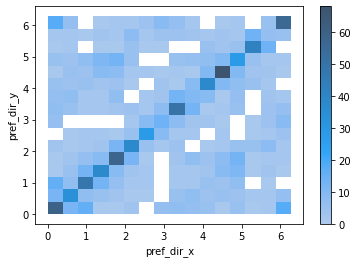

In [41]:
f, ax = plt.subplots()
sns.histplot(data=dsi_self2, x='pref_dir_x', y='pref_dir_y',bins=16, ax=ax, cbar=True)


In [42]:
dsi_self2.shape

(1586, 33)

In [43]:
dsi_self2[['session_x', 'scan_idx_x', 'unit_id_x']].value_counts()

session_x  scan_idx_x  unit_id_x
6          2           6616         24
           6           6252         18
5          7           7117         12
6          6           7170         12
8          5           2054         12
                                    ..
6          6           4594          1
5          7           2060          1
6          6           4671          1
                       4714          1
           7           3242          1
Length: 1026, dtype: int64

In [47]:
len(dsi_self2[(dsi_self2.dsi_y +dsi_self2.dsi_x)/2  > 0.3])

40

In [48]:
dsi_self2.columns

Index(['id_x', 'valid_x', 'pt_supervoxel_id_x', 'pt_root_id', 'session_x',
       'scan_idx_x', 'unit_id_x', 'pt_position_x', 'animal_id_x',
       'scan_session_x', 'direction_x', 'response_mean_x', 'osi_x', 'dsi_x',
       'pref_dir_x', 'pref_ori_x', 'oracle_x', 'id_y', 'valid_y',
       'pt_supervoxel_id_y', 'session_y', 'scan_idx_y', 'unit_id_y',
       'pt_position_y', 'animal_id_y', 'scan_session_y', 'direction_y',
       'response_mean_y', 'osi_y', 'dsi_y', 'pref_dir_y', 'pref_ori_y',
       'oracle_y'],
      dtype='object')

In [52]:
dsi_self2[(dsi_self2.dsi_y +dsi_self2.dsi_x)/2  > 0.3].pt_root_id

154      864691135446633812
155      864691135446633812
406      864691135415493050
407      864691135415493050
779      864691135229012362
780      864691135229012362
781      864691135229012362
782      864691135229012362
784      864691135229012362
785      864691135229012362
786      864691135229012362
787      864691135229012362
789      864691135229012362
790      864691135229012362
791      864691135229012362
792      864691135229012362
1678     864691135445539474
1679     864691135445539474
2160     864691135517422218
2161     864691135517422218
2162     864691135517422218
2164     864691135517422218
2165     864691135517422218
2166     864691135517422218
4264     864691135807308573
4266     864691135807308573
5738     864691135360229703
5739     864691135360229703
7806     864691135997647306
7807     864691135997647306
9377     864691135771971659
9378     864691135771971659
9501     864691136134413451
9502     864691136134413451
10475    864691135462735773
10476    86469113546

In [ ]:
# put condtions there: 
dsi_self2.query()